# Coursework 1: Convolutional Neural Networks 
### Autograding
Part 1 of this coursework is autograded. This notebook comes with embedded tests which will verify that your implementations provide outputs with the appropriate types and shapes required for our hidden tests. You can run these same public tests through [LabTS](https://teaching.doc.ic.ac.uk/labts) when you have finished your work, to check that we get the same results when running these public tests.

Hidden tests will be ran after the submission deadline, and cannot be accessed :)

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory or Paperspace, where you can access GPUs.

You should receive an email at your imperial address inviting you to join the course team on PaperSpace (within a day of the coursework being released).

#### Paperspace
See [the Paperspace information doc](https://hackmd.io/@afspies/S1stL8Qnt). 

The public tests are embedded within the notebook. You can ignore the "tests" folder as it is only required for colab.


#### Google Colab
To run this notebook on Google Colab, please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

**To run the public tests within colab** you will need to copy the "tests" folder to the /content/ directory (this is the default working directory - you can also change directories with %cd). You may also need to place a copy of the CW ipynb in the /content/ directory. A better option is to mount colab on gdrive and keep the files there (so you only need to do the set up once).

#### Setup
You will need to install pytorch and other libraries by running the following cell:

In [2]:
!pip install -q otter-grader pandoc torch torchvision scikit-learn seaborn

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.21.12 which is incompatible.
tensorboard 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.21.12 which is incompatible.


In [3]:
# Initialization Cell
import otter
grader = otter.Notebook("dl_cw_1.ipynb")
import matplotlib.pyplot as plt # DO NOT use %matplotlib inline in the notebook
import numpy as np
rng_seed = 90

## Introduction
In this courswork you will explore various deep learning functionalities through implementing a number of pytorch neural network operations/layers and creating your own deep learning model and methodology for a high dimensional classification problem.

#### Intended learning outcomes
- An understanding of the mechanics behind convolutional, pooling, linear and batch norm operations. 
- Be able to implement convolution, pooling, linear and batch norm layers from basic building blocks.
- Experience designing, implementing and optimising a classifier for a high dimensional dataset.

## Part 1 (50 points)

In this part, you will use basic Pytorch operations to define the 2D convolution, 2D max pooling, linear layer, as well as 2D batch normalization operations. Being computer scientists we care about efficiency, we therefore do not want to see any _for loops_!

**Your Task**
- Implement the forward pass for Conv2D (15 points), MaxPool2D (15 points), Linear (5 points) and BatchNorm2d (15 points)
- You are **NOT** allowed to use the torch.nn modules (The one exception is that the class inherits from nn.Module)

_hint: check out F.unfold and F.fold, they may be helpful_

# **CONVOLUTION**

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height H' and width W'.

        Parameters:
        - w: Filter weights of shape (F, C, H', W',)
        - b: Biases of shape (F,)
        - kernel_size: Union[int, (int, int)], Size of the convolving kernel
        - stride: Union[int, (int, int)], Number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: Union[int, (int, int)], Number of pixels that will be used to zero-pad the input.
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Define the parameters used in the forward pass

        # Do not initialize weights or biases with torch.empty() but rather use torch.zeros()
        # Weights should have shape [out_channels, in_channels, kernel_y, kernel_x] CHANGED !
        
        if type(kernel_size) is not int:
            shape = (out_channels, in_channels, kernel_size[1], kernel_size[0])
        else:
            shape = (out_channels, in_channels, kernel_size, kernel_size)
            
        self.w = torch.zeros(size=shape)
        
        # Bias should have shape [out_channels] 
        self.b = torch.zeros(size=(out_channels,))
        
        self.F = out_channels
        self.C = in_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Implement the forward pass                                     #
        
        stride = self.stride
        h_in, w_in = x.shape[2], x.shape[3]

        padding = self.padding  # + k//2
        batch_size = x.shape[0]

        if type(padding) == tuple:
            padding_h = padding[0]
            padding_w = padding[1]
        else:
            padding_h = padding
            padding_w = padding

        if type(stride) == tuple:
            stride_h = stride[0]
            stride_w = stride[1]
        else:
            stride_h = stride
            stride_w = stride

        if type(self.kernel_size) == tuple:
            kernel_size_h = self.kernel_size[0]
            kernel_size_w = self.kernel_size[1]
        else:
            kernel_size_h = self.kernel_size
            kernel_size_w = self.kernel_size

        # print()
        # print("{0:30}{1}".format("(kernel_size_h, kernel_size_w)", (kernel_size_h, kernel_size_w)))
        # print("{0:30}{1}".format("(stride_h, stride_w)", (stride_h, stride_w)))
        # print("{0:30}{1}".format("(padding_h, padding_w)", (padding_h, padding_w)))

        h_out = (h_in + 2 * padding_h - (kernel_size_h - 1) - 1) / stride_h + 1
        w_out = (w_in + 2 * padding_w - (kernel_size_w - 1) - 1) / stride_w + 1
        h_out, w_out = int(h_out), int(w_out)

        # print("{0:30}{1}".format("(h_in, w_in)", (h_in, w_in)))
        # print("{0:30}{1}".format("(h_out, w_out)", (h_out, w_out)))

        inp_unf = F.unfold(x, self.kernel_size, stride=stride, padding=padding)

        # print("{0:30}{1}".format("inp_unf.shape", inp_unf.shape))

        out_unf = inp_unf.transpose(1, 2).matmul(self.w.view(self.w.size(0), -1).t()).transpose(1, 2) + self.b.view(-1, 1)

        # print("{0:30}{1}".format("out_unf.shape", out_unf.shape))
        
        out = F.fold(out_unf, (h_out, w_out), (1, 1))
        
        # print("{0:30}{1}".format("out.shape", out.shape))

        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out 

In [6]:
grader.check("Convolution Layer")

Convolution Layer results: All test cases passed!
Convolution Layer - 1 message: Shape Test Passed
Convolution Layer - 2 message: Type Test Passed
Convolution Layer - 3 message: Param Name Test Passed
Convolution Layer - 4 message: Param Shape Test Passed

# **MAX POOLING**

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: Union[int, (int, int)], the size of the window to take a max over
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.kernel_size = kernel_size
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, C, H', W').
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        h_in, w_in = x.shape[2], x.shape[3]
        channels = x.shape[1]
        batch_size = x.shape[0]

        h_out = h_in // self.kernel_size
        w_out = w_in // self.kernel_size
        
        int_tensor = F.unfold(x, (self.kernel_size), stride=self.kernel_size)
        
        inp_unf = torch.reshape(int_tensor, (batch_size, channels, int(int_tensor.shape[1]/channels), int_tensor.shape[2]))
        
        out_unf = torch.max(inp_unf, 2).values
        
        out = F.fold(out_unf, (h_out, w_out), (1, 1))
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [9]:
grader.check("MaxPool Layer")

MaxPool Layer results: All test cases passed!
MaxPool Layer - 1 message: Shape Test Passed
MaxPool Layer - 2 message: Type Test Passed

# **LINEAR**

In [10]:


# NEW FOR TESTING

class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        # TODO: Define the parameters used in the forward pass                 #
        # **START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)**

        # self.register_parameter is not used as it was mentioned on piazza
        # that this will be overridden
        # Also no initialisation methods for this reason
        self.w = torch.zeros((out_channels, in_channels))
        self.b = torch.zeros(out_channels)
        # **END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)**

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        # TODO: Implement the forward pass                                     #
        # **START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)**

        out = torch.matmul(x, self.w.t()) + self.b
        
        # **END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)**
        return out

In [12]:
grader.check("Linear Layer")

Linear Layer results: All test cases passed!
Linear Layer - 1 message: Shape Test Passed
Linear Layer - 2 message: Type Test Passed
Linear Layer - 3 message: Param Name Test Passed
Linear Layer - 4 message: Param Shape Test Passed

In [18]:
class BatchNorm2d(nn.Module):
	def __init__(self, num_features, eps=1e-05, momentum=0.1):
		super(BatchNorm2d, self).__init__()
		"""
		An implementation of a Batch Normalization over a mini-batch of 2D inputs.

		The mean and standard-deviation are calculated per-dimension over the
		mini-batches and gamma and beta are learnable parameter vectors of
		size num_features.

		Parameters:
		- num_features: C from an expected input of size (N, C, H, W).
		- eps: a value added to the denominator for numerical stability. Default: 1e-5
		- momentum: the value used for the running_mean and running_var
		computation. Default: 0.1 . (i.e. 1-momentum for running mean)
		- gamma: the learnable weights of shape (num_features).
		- beta: the learnable bias of the module of shape (num_features).
		"""
		# TODO: Define the parameters used in the forward pass                 #
		# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
		
		self.num_features = num_features
		self.eps = eps
		self.momentum = momentum

		# self.register_parameter is not used as it was mentioned on piazza
		# that this will be overridden
		self.gamma = torch.zeros(size=(1, num_features, 1, 1))
		self.beta = torch.zeros(size=(1, num_features, 1, 1))
		
		self.moving_mu = torch.zeros(size=(1, num_features, 1, 1))
		
		self.moving_sigma = torch.zeros(size=(1, num_features, 1, 1))
		
		# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

	def forward(self, x):
		"""
		During training this layer keeps running estimates of its computed mean and
		variance, which are then used for normalization during evaluation.
		Input:
		- x: Input data of shape (N, C, H, W)
		Output:
		- out: Output data of shape (N, C, H, W) (same shape as input)
		"""
		# TODO: Implement the forward pass                                     #
		#       (be aware of the difference for training and testing)          #
		# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
		
		if torch.is_grad_enabled():
			mean = torch.mean(x, dim=(0, 2, 3), keepdim=True)
			var = torch.var(x, dim=(0, 2, 3), keepdim=True)
			
			x = (x - mean) / torch.sqrt(var + self.eps)

			self.moving_mu = self.moving_mu * self.momentum + (1.0 - self.momentum) * mean
			self.moving_sigma = var * (1.0 - self.momentum) + self.momentum * self.moving_sigma
		else:
			x = (x - self.moving_mu) / torch.sqrt(self.moving_sigma + self.eps)
		
		x = self.gamma * x - self.beta

		# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
		return x

In [17]:
grader.check("BatchNorm Layer")

BatchNorm Layer results: All test cases passed!
BatchNorm Layer - 1 message: Shape Test Passed
BatchNorm Layer - 2 message: Type Test Passed
BatchNorm Layer - 3 message: Param Name Test Passed
BatchNorm Layer - 4 message: Param Shape Test Passed

## Part 2 (40 points)

In this part, you will design, train and optimise a custom deep learning model for classifying a specially selected subset of Imagenet. Termed NaturalImageNet, it is made up of a hand selected subset of the famous ImageNet dataset. The dataset contains 20 classes, all animals from the natural world. We hope that this dataset will be fun to work with but also a challenge.

You will be marked on your experimental process, methods implemented and your reasoning behind your decisions. While there will be marks for exceeding a baseline performance score we stress that students should **NOT** spend excessive amounts of time optimising performance to silly levels.

We have given you some starter code, please feel free to use and adapt it.

**Your Task**
1. Develop/adapt a deep learning pipeline to maximise performance on the test set. (30 points)
    * 10 points will be awarded for improving on the baseline score on the test set. Don't worry you can get full marks here by improving by a minor amount.
    * 20 points will be awarded for the adaptations made to the baseline model and pipeline.

2. Answer the qualititative questions (10 points)

**Downloading NaturalImageNet**

In [16]:
ON_COLAB = False

#!wget https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1
#!wget https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1
#if ON_COLAB:
#    !unzip /content/NaturalImageNetTest.zip?download=1 > /dev/null
#    !unzip /content/NaturalImageNetTrain.zip?download=1 > /dev/null
#else: 
#    !unzip NaturalImageNetTest.zip?download=1 > /dev/null
#    !unzip NaturalImageNetTrain.zip?download=1 > /dev/null

In [17]:
ON_COLAB = False

#torch
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms            # these are used to better transform the stuff
from torchvision.utils import save_image, make_grid
#other
import matplotlib.pyplot as plt
import numpy as np
# set the seed for reproducibility
rng_seed = 90
torch.manual_seed(rng_seed)

In [39]:
# When we import the images we want to first convert them to a tensor. 
# It is also common in deep learning to normalise the the inputs. This 
# helps with stability.
# To read more about this subject this article is a great one:
# https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0

# transforms is a useful pytorch package which contains a range of functions
# for preprocessing data, for example applying data augmentation to images 
# (random rotations, blurring the image, randomly cropping the image). To find out
# more please refer to the pytorch documentation:
# https://pytorch.org/docs/stable/torchvision/transforms.html

mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

# Unchanged transformation for the test dataset
transform_test = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]
    )

# DATA AUGMENTATION

# Manual transformation for the training dataset
degrees = 35

gaussian_blur = transforms.RandomApply(torch.nn.ModuleList([transforms.GaussianBlur(kernel_size=11)]),      p=0.14)
color_jitter = transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]),                      p=0.4)
random_rotation = transforms.RandomApply(torch.nn.ModuleList([transforms.RandomRotation(degrees)]),         p=0.14)
vertical_flip = transforms.RandomApply(torch.nn.ModuleList([transforms.RandomHorizontalFlip()]),            p=0.14)
random_perspective = transforms.RandomApply(torch.nn.ModuleList([transforms.RandomPerspective(0.3)]),       p=0.14)
random_sharpness_down = transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAdjustSharpness(0.5)]),p=0.14)
random_sharpness_up = transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAdjustSharpness(1.5)]),  p=0.14)
random_affine = transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAffine(degrees)]),             p=0.14)
random_posterize = transforms.RandomApply(torch.nn.ModuleList([transforms.RandomPosterize(bits=2)]),        p=0.14)
random_resized = transforms.RandomApply(torch.nn.ModuleList([transforms.RandomResizedCrop(size=(12, 12))]), p=0.14)


transform_train_manual_implementation = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
            gaussian_blur,
            color_jitter,
            random_sharpness_down,
            random_affine,
            random_perspective,
            random_rotation,
            random_sharpness_up,
            vertical_flip,
        ]
    )

train_path = ('/content/' if ON_COLAB else '') + 'NaturalImageNetTrain'
test_path = ('/content/' if ON_COLAB else '') + 'NaturalImageNetTest'

# Cleaning the datasets using the transformations + DUPLICATE THE TRAINING SET INTO AUGMENTED AND NON-AUGMENTED
train_dataset = datasets.ImageFolder(train_path, transform=transform_train_manual_implementation)
test_dataset = datasets.ImageFolder(test_path, transform=transform_test)
non_transformed_train_dataset = datasets.ImageFolder(train_path, transform=transform_test)
train_dataset = torch.utils.data.ConcatDataset([train_dataset, non_transformed_train_dataset])

# Create train val split
n = len(train_dataset)      # Train is 90 percent
n_val = int(n/10)           # Val is 10 percent

train_set, val_set = torch.utils.data.random_split(train_dataset, [n-n_val, n_val])


print(len(train_set), len(val_set), len(test_dataset))


# The number of images to process in one go. If you run out of GPU
# memory reduce this number!

batch_size = 128

# Dataloaders are a great pytorch functionality for feeding data into our AI models.
# see https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader
# for more info.

loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

35972 3996 2000


In [32]:
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x):
    '''
    Function to reverse the normalization so that we can visualise the outputs
    '''
    x = unnormalize(x)
    x = x.view(x.size(0), 3, 256, 256)
    return x

def show(img):
    '''
    function to visualise tensors
    '''
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)).clip(0, 1))

**Visualising some example images** 

torch.Size([27, 3, 256, 256])


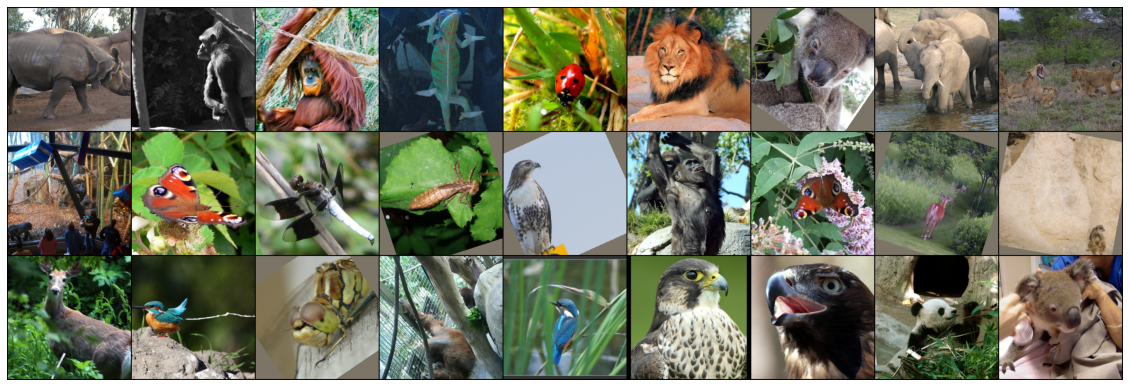

In [40]:
sample_inputs, _ = next(iter(loader_val))
fixed_input = sample_inputs[:27, :, :, :]

print(fixed_input.shape)

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

# Neural Network

In [41]:
class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 

        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True),
                                  Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential()
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) )
            
    def forward(self, x): 
        
        out = self.left(x) 
        out += self.shortcut(x) 
        out = F.relu(out)                                           
        
        return out


class ResNet(nn.Module): 
    def __init__(self, ResidualBlock, num_classes = 20):

            super(ResNet, self).__init__()

            # Widened the first convolution layer from 16 to 64 feature maps.
            self.inchannel = 64
            self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = 3, stride = 1,
                                                padding = 1, bias = False), 
                                      nn.BatchNorm2d(64), 
                                      nn.ReLU())

            # Widened the following layers too and decrease the number of blocks.
            self.layer1 = self.make_layer(ResidualBlock, 128, 1, stride = 2)    
            self.layer2 = self.make_layer(ResidualBlock, 256, 2, stride = 2) 
            self.layer3 = self.make_layer(ResidualBlock, 512, 2, stride = 2)

            # Funnel-like architecture to better extract information from the 512 feature maps
            self.layer4 = self.make_layer(ResidualBlock, 128, 1, stride = 2)
            self.layer5 = self.make_layer(ResidualBlock, 64, 1, stride = 2)

            # Changed Maxpooling to Average pooling
            self.maxpool = nn.AvgPool2d(4)

            # Funnel-like structure enabled decrease in parameters
            self.fc = nn.Linear(256, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)

        layers = []

        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels

        # print("{0:20}{1}".format("Added block:", layers))

        return nn.Sequential(*layers)


    def forward(self, x):

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

 Visualize the data:

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def confusion(preds, y):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # Plotting the confusion matrix
  cm = confusion_matrix(y.cpu().numpy(), preds.cpu().numpy(), normalize='true')
  fig, ax= plt.subplots(1, 1, figsize=(15,10))
  sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(labels, rotation = 70); ax.yaxis.set_ticklabels(labels, rotation=0);
  plt.show()

def incorrect_preds(preds, y, test_img):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # lets see a sample of the images which were classified incorrectly!
  correct = (preds == y).float()
  test_labels_check = correct.cpu().numpy()
  incorrect_indexes = np.where(test_labels_check == 0)

  test_img = test_img.cpu()
  samples = make_grid(denorm(test_img[incorrect_indexes][:9]), nrow=3,
                      padding=2, normalize=False, value_range=None, 
                      scale_each=False, pad_value=0)
  plt.figure(figsize = (20,10))
  plt.title('Incorrectly Classified Instances')
  show(samples)
  labels = np.asarray(labels)
  print('Predicted label',labels[preds[incorrect_indexes].cpu().numpy()[:9]])
  print('True label', labels[y[incorrect_indexes].cpu().numpy()[:9]])
  print('Corresponding images are shown below')

Functions to train the model

In [44]:

def display_final_results(train_loss, val_loss, early_stopping_epoch_number=None):
    
    params = {"ytick.color" : "black",
                "xtick.color" : "black",
                "axes.labelcolor" : "black",
                "axes.edgecolor" : "black",}
    
    plt.rcParams.update(params)
    plt.figure(figsize=(15, 8))
    
    train_array = np.array(train_loss)    
    val_array = np.array(val_loss)

    maximum_loss = max(np.max(train_array), np.max(train_array))
    minimum_loss = min(np.min(train_array), np.min(train_array))

    delta = maximum_loss - 0

    plt.ylim(0, maximum_loss + 0.07*delta)

    plt.plot([epoch/2 for epoch in range(1, 1+len(val_loss))], train_array, 's-g', label='Training loss', linewidth=2)
    plt.plot([epoch/2 for epoch in range(1, 1+len(val_loss))], val_array, 's-b', label='Validation loss', linewidth=2)

    if early_stopping_epoch_number:
        plt.plot([early_stopping_epoch_number, early_stopping_epoch_number], [maximum_loss * 10, -1], '--r', label='Early stopping', linewidth=4)

    plt.ylabel("Loss", fontsize=25, fontweight ='bold')
    plt.xlabel("Epochs", fontsize=25, fontweight ='bold')
    
    title_name = "Evolution of the training and validation loss as a function of epoch number"
    plt.title(title_name, fontsize=20, fontweight ='bold')

    plt.grid()
    plt.legend()

    plt.show()


USE_GPU = True
dtype = torch.float32 


if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)
    
def check_accuracy(loader, model, analysis=False, display_message=True):
    # function for test accuracy on validation and test set
    
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    total_loss = 0
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)

            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            if t == 0 and analysis:
              stack_labels = y
              stack_predicts = preds
            elif analysis:
              stack_labels = torch.cat([stack_labels, y], 0)
              stack_predicts = torch.cat([stack_predicts, preds], 0)

            # ADDED TO CALCULATE THE LOSS OF THE VALIDATION DATASET

            loss = F.cross_entropy(scores, y)
            total_loss += loss / len(loader)

        acc = float(num_correct) / num_samples

        if display_message:
            print('Got %d / %d correct of val set (%.2f)' % (num_correct, num_samples, 100 * acc))

        if analysis:
          print('check acc', type(stack_predicts), type(stack_labels))
          confusion(stack_predicts, stack_labels)
          incorrect_preds(preds, y, x)
        return float(acc), float(total_loss)

        
def train_part(model, optimizer, epochs=1, print_every=10):
    """
    Train a model on NaturalImageNet using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """

    validation_loss = []
    training_loss = []

    model = model.to(device=device)  # move the model parameters to CPU/GPU

    loss_to_beat = 999
    early_stopping_threshold = 4 # This is 4 half epochs
    stopping_epoch = None

    for e in range(epochs):

        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            # if t % print_every == 0:
            #    print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
            
            if t == int(len(loader_train)/2):
                acc, val_loss = check_accuracy(loader_val, model, display_message=False)
                validation_loss.append(val_loss)
                training_loss.append(float(loss.item()))
                print_update(e+0.5, training_loss[-1], validation_loss[-1])

                if val_loss < loss_to_beat:
                    loss_to_beat = val_loss
                    torch.save(model.state_dict(), 'model.pt')
                    count = 0
                    #print("Updated the network")
                else:
                    count += 1
                    if count >= early_stopping_threshold:
                        stopping_epoch = e + 1 - early_stopping_threshold / 2
                        #print("BREAK")
                        break
                    else:
                        #print(f"did not update the network since {val_loss} > {loss_to_beat}. Count: {count}")
                        continue

        acc, val_loss = check_accuracy(loader_val, model, display_message=False)
        validation_loss.append(val_loss)
        training_loss.append(float(loss))
        print_update(e+1, training_loss[-1], validation_loss[-1])

        if val_loss < loss_to_beat:
            loss_to_beat = val_loss
            torch.save(model.state_dict(), 'model.pt')
            count = 0
            #print("Updated the network")

        else:
            count += 1
            if count >= early_stopping_threshold:
                stopping_epoch = e + 1 - early_stopping_threshold / 2
                #print(f"BREAK")
                break
            else:
                #print(f"did not update the network since {val_loss} > {loss_to_beat}. Count: {count}")
                continue
    
    display_final_results(train_loss=training_loss, val_loss=validation_loss, early_stopping_epoch_number=stopping_epoch)

def print_update(epoch_number, training_loss, validation_loss):
    print("\n{0:9} Epoch No. {1}\n".format("", epoch_number))
    print("{0:28}{1:.3f}".format("Training Loss:", training_loss))
    print("{0:28}{1:.3f}\n".format("Validation Loss:", validation_loss))
                

cuda:0


Actual Training of the model and testing

Total number of parameters is: 11653332

          Epoch No. 0.5

Training Loss:              1.998
Validation Loss:            2.110


          Epoch No. 1

Training Loss:              2.619
Validation Loss:            1.842


          Epoch No. 1.5

Training Loss:              1.419
Validation Loss:            1.611


          Epoch No. 2

Training Loss:              0.754
Validation Loss:            1.407


          Epoch No. 2.5

Training Loss:              1.329
Validation Loss:            1.722


          Epoch No. 3

Training Loss:              1.052
Validation Loss:            1.403


          Epoch No. 3.5

Training Loss:              0.865
Validation Loss:            1.208


          Epoch No. 4

Training Loss:              1.500
Validation Loss:            2.038


          Epoch No. 4.5

Training Loss:              0.683
Validation Loss:            1.128


          Epoch No. 5

Training Loss:              1.147
Validation Loss:            0.990


          Epoch No.

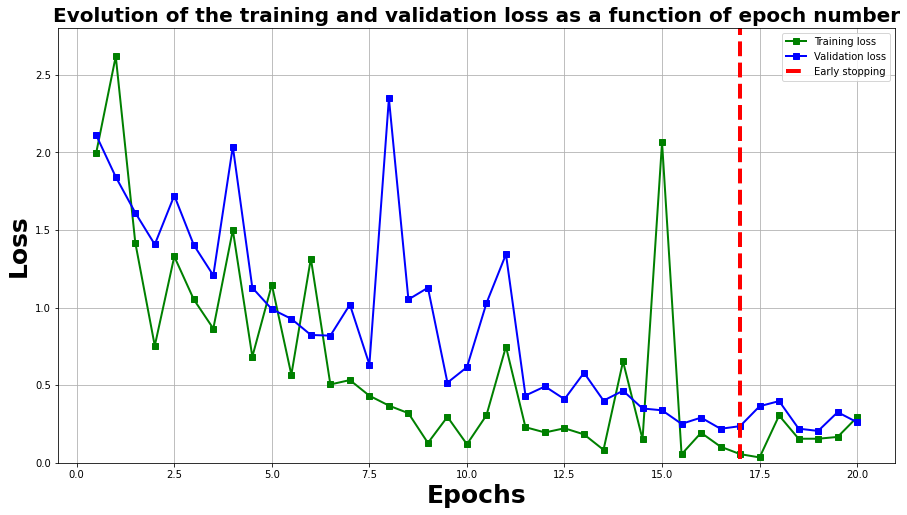

Got 3684 / 3996 correct of val set (92.19)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


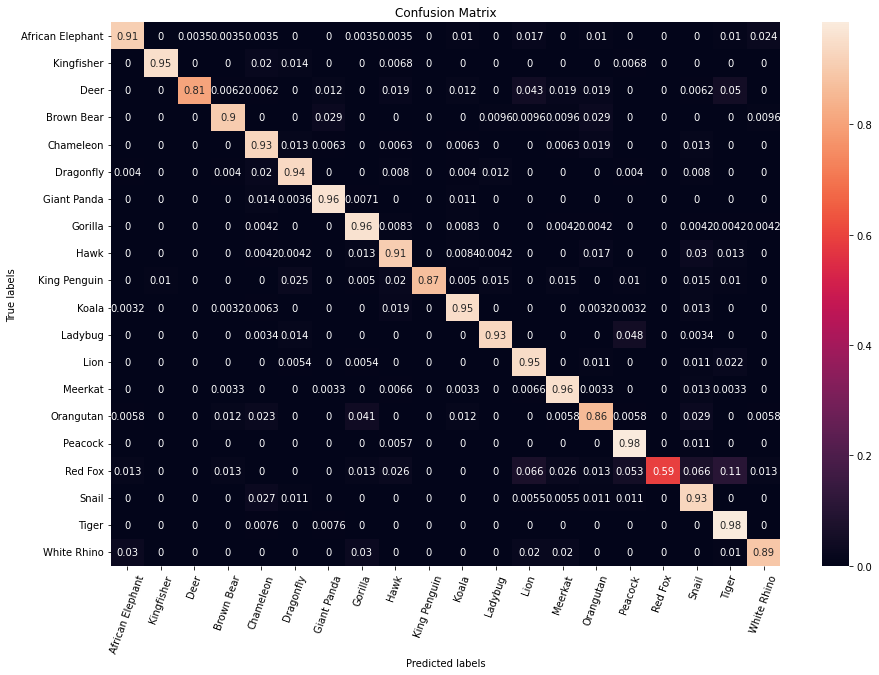

Predicted label ['Snail' 'Gorilla']
True label ['King Penguin' 'African Elephant']
Corresponding images are shown below


(0.9219219219219219, 0.26662588119506836)

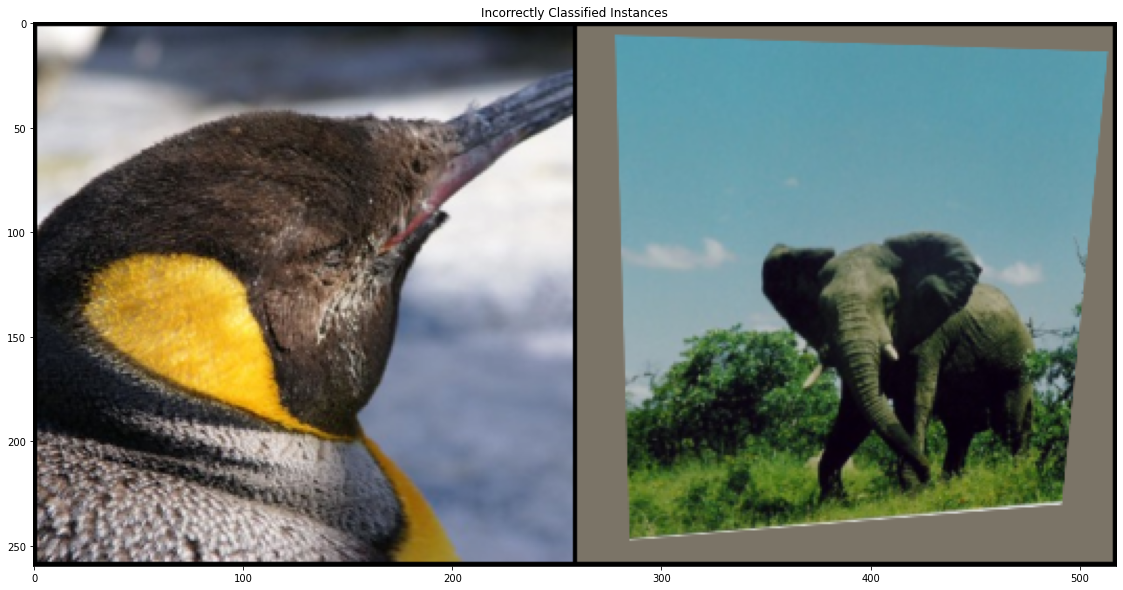

In [45]:
# define and train the network
model = MyResNet()
optimizer = optim.Adamax(model.parameters(), lr=0.0005, weight_decay=1e-7) # Decreased the learning rate to 0.0002

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

train_part(model, optimizer, epochs = 20)

# report test set accuracy
check_accuracy(loader_val, model, analysis=True)

---

<!-- BEGIN QUESTION -->

### Network Performance

Run the code below when all engineering decisions have been made, do not overfit to the test set!

**Note that** this will appear in the output, and be checked by markers (so ensure it is present in the auto-export)

Got 1690 / 2000 correct of val set (84.50)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


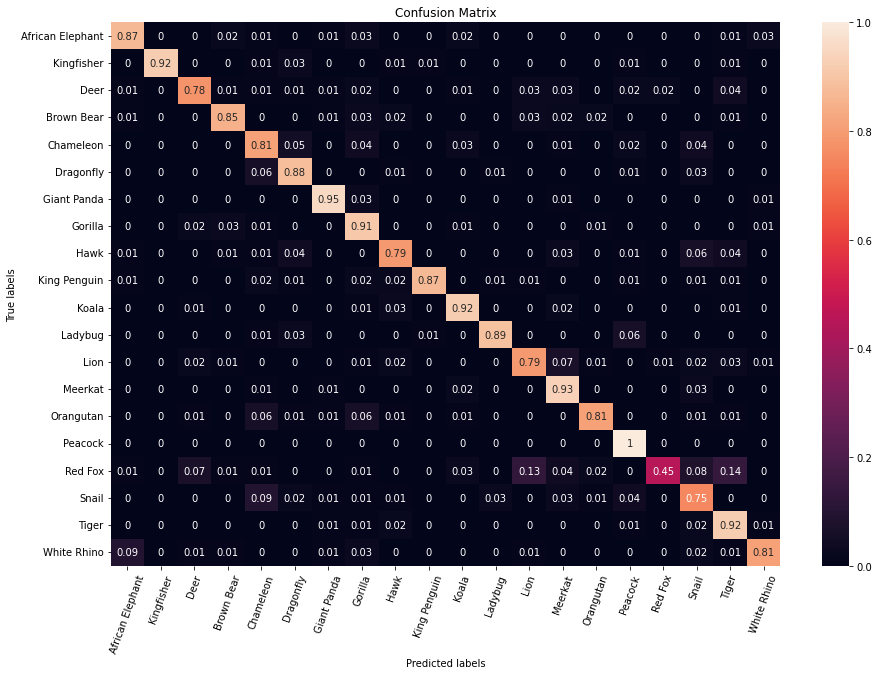

Predicted label ['Snail' 'Lion' 'Snail' 'Hawk' 'Dragonfly' 'Gorilla' 'African Elephant'
 'Peacock' 'Hawk']
True label ['Red Fox' 'White Rhino' 'Red Fox' 'King Penguin' 'Ladybug' 'Giant Panda'
 'White Rhino' 'Snail' 'Orangutan']
Corresponding images are shown below


(0.845, 0.5194213390350342)

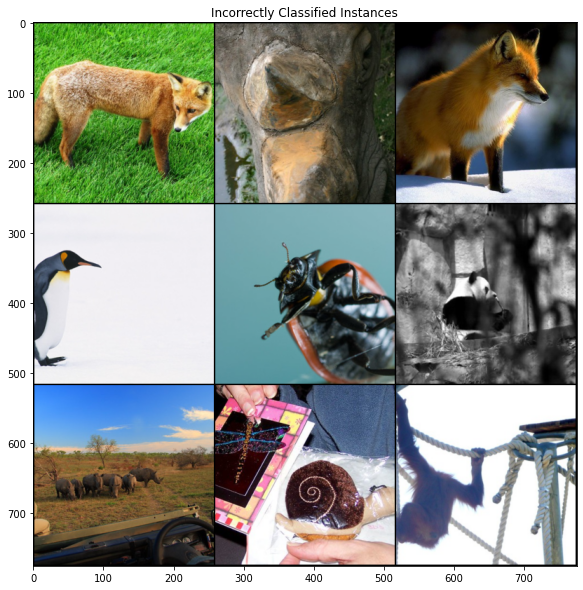

In [46]:
# Run once your have trained your final model
check_accuracy(loader_test, model, analysis=True)

___

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.1: Hyperparameter Search:
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? (3 points)

**Answer:**

A neural network is only as good as the tuning it has undergone to fit the task at stake. However, searching is expensive with deep neural networks (DNN) and the space of possibility arising from the numerous hyperparameters involved is immense. Therefore, a strategy based on a sound understanding of the underlying mechanisms involved in DNN is important to speed up the process while still exploring the interesting hyperparameter combinations for the model.

A Bayesian Optimization type strategy could be conducted, which is simply an intelligent trial and error method:

1. Find a promising hyperparameter combination to explore
2. Train the model
3. Evaluate the model
4. Assess based on the score obtained which combination should be explored next

Furthermore, the types of hyperparameters to tune first should be the ones that bear the most impact on the network's performance. As such, the following hyperparameters will be tune in order, though it can be hard to know which will impact the performance most: 

- Width and depth of the network
- Activation/loss functions
- Data Augmentation 
- Learning rate
- Optimizer
- Limitting overfitting with early stopping

First, parameters relative to the network are tuned, this includes its structure and activation/loss functions. Only then should Data augmentation be implemented, as it depends on the structure and capability of the network. Indeed, some smaller networks will not be able to adapt to large data transformations, while larger ones need it to be forced on focusing on shapes or other desired stable features. Similarly, the learning rate and optimizers used depend on the structure of the network and the data augmentation procedure followed, since it will impact the learning of the network. Therefore, it should be tuned last. Eventually, if overfitting is present, early stopping should be implemented and the correct number of epochs for stopping to be triggered should also be tuned.


---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.2: Engineering Decisions 

Detail which engineering decisions you made to boost the performance of the baseline results. Why do you think that they helped? (7 points)

**Answer:**

Multiple engineering decisions have been made for this network. They are summerized in the following table.

| Modification No. | Implementation | Explanation for change |
| :-: | :- | :-: |
| 1 | Wider network:<ul><li>Modified 1st convolutional layer to have 64 filters instead of 16</li><li>Add 128-filter convolutional layer</li><li>Add 512-filter convolutional layer</li><li>Changed max pooling to average pooling</li></ul>| A wider architecture benefited the Network|
| 2 | Shallower network:<ul><li>Erase the first 2 thin layers</li><li>Decreased number of blocks per layer</li></ul>| Wider network proved a better use of memory than a deeper one |
| 3 | Funnel-like architecture:<ul><li>Add a one-block layer of 128 feature maps after the 512 one</li><li>Add a one-block layer of 64 feature maps after the 128 one</li></ul>| Transition from wide-middle-layer to output-layer was too abrupt |
| 4 | Data Augmentation (DA) with own transformation set:<ul><li>Gaussian blur</li><li>Color jitter</li><li>Random rotation</li><li>Random perspective</li><li>Random sharpness</li><li>Random affine transformation</li><li>Random posterize</li><li>Random vertical flip</li></ul>| Data augmentation forces the model to generalize |
| 5 | Duplicate training sets:<ul><li>Half undergo standard transformations</li><li>Half undergo more DA modified to be more agressive</li></ul>| Increased training data while still forcing the network to better generalize |
| 6 | Increased learning rate from 0.0001 to 0.0005 | Helped the model converge |
| 7 | Implemented early stopping with threshold of 5 | Helped mitigate overfitting of the model |

**Modification 1: Wider Network**

Wider and deeper networks are said to greatly impact performance. Therefore, the first modification made was to widen the first layers to immediately form 64 feature maps. The following layers were also made wider. As this modification greatly increased the number of parameters, it affected memory usage. This implied a trade-off between a width and depth of the network had to be found. Upon playing with the network's architecture, it appeared that width provided better result. This lead to modification number 2. Also, the max pooling was replaced with an average pooling which improved results for reasons still unclear.

**Modification 2: Shallower Network for memory gain**

The previous modification was made possible by this one. Indeed, it was decided to delete the first two layers containing 16 and 32 feature maps. Also, some layers were made shallower by removing a block.

**Modification 3: Funnel-like structure**

 Then, a funnel-like ending architecture was implemented to smooth the abrupt transition from the fully connected layer to the output layer. As such, 2 convolution layers were added: one of 128 filters and another of 64 filters. The memory increase from those additional layers was balanced by the decrease in the number of parameter of the final fully connected layer, thanks to the smoother transition. Indeed, the FC layer went from 8192 input neurons to only 256. This funnel structure helped better extract the useful bits of information from the numerous features maps.

**Modification 4: Data Augmentation (DA) with own transformation set**

Data Augmentation is an efficient method for forcing the model to generalize better by introducing some transformations on the train set. There exist multiple already-made tools to augment one's data, even policy made specifically for the ImageNet dataset. Implementing AutoAugment and RandAugment, the model's accuracy plummeted. This is likely due to the transformations being too aggressive for the network. Indeed, the network might be too small and does not have sufficient learning capabilities to generalize sufficiently. Therefore, a handmade transformation set was constructed that included many diverse transformations. Images were transformed enough for the network to be forced to generalize, but not too much that the network could not keep up.

**Modification 5: Duplicate training sets**

The data augmentation mentioned was done on the training set directly. Duplicating the training set and applying transformations to one of those effectively increased the training data available. The transformations could hence also be made more aggressive. The combination of more training data with more aggressive transformations helped the network in perfecting its learning.

**Modification 6: Learning Rate**

Playing on the learning rate, a balance was found between a large learning rate that would allow faster convergence but to sub-optimal sets of weights, and a low learning rate that slows the training stage but leads to better performance. For this network's architecture, the best learning rate has been found to be around 0.0005.

**Modification 7: Early Stopping**

The model was overfitting so an early stop was implemented. Through experimentation, a threshold of 5 epochs was deemed best.

---

<!-- END QUESTION -->

## Part 3 (10 points)

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions*(: 

<!-- BEGIN QUESTION -->

### Q3.1 : Learned Features

Compare the feature maps from low-level layers to high-level layers, what do you observe? (4 points)

**Answer:**

The feature maps from low-level layers are understandable by a human eye. They highlight different general aspects of the images, mostly differentiating on the background, serving as a fundation for the next layers to identify edges and other more specific and precise features. The deeper the layer, the more complex the relations and the harder it becomes for a human to comprehend the feature maps. From layer 3 onwards, the penguin on the feature maps become unrecognizable, revealing the extent of the complex relations formed by the network. It is unclear for a human how the network makes a decision based on the last layer.

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.2: Performance Analysis

Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance? (4 points)

**Answer:**

The accuracy achieved of 85% is quite good and might be difficult to beat without enlarging the structure of the network. Indeed, although the network is already quite large, the image classification task at stake is not an easy one, having tricky images with confusing backgrounds and lots of labels. Therefore, I suspect the network has almost reached its full potential, given its size: deeper, wider networks should have more learning abilities and manage more intricate/complex relations, necessary to correctly classify the more confusing images. Right now, it is images of red foxes that pose problem. The network is mistaking them for pictures of lions or tigers, which are not far-off in real life. Distinguishing between the three classes is not easy and attributes like shape/colour is not sufficient anymore.


However, it might still be slightly improved by better tuning of the learning rate, experimenting with more optimizers (only NAdam, AdamW and Adamax were tried) and even trying for different batch size since this sometimes affect performance. Also, upsampling fox images might help better recognize them.

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.3: Alternative Evaluations

What are the other possible ways to analyse the performance of your network? (2 points)

**Answer:**

There exist numerous ways to analyse the performance of a machine learning algorithm. These include metrics such as the recall, the accuracy, the F1 score (which is a combination of recall and precision)... These evaluation methods could also be applied to individual classes, to better understand how the network performs on identifying each animal. In some circumstances, it might be more important to identify foxes which could be a worry if this model were used. 

There also exist other metrics to evaluate performance of neural networks specifically. Speed of training could be of interest measured by FLOPs, or how memory-intense the network is, measured by the number of parameters involved mostly.

It mainly depends on the user's requirements.

---

<!-- END QUESTION -->

**Feature Visualization**

The code below will visualize the features of your network layers (you may need to modify the layer names if you made changes to your architecture). 

If you change the plotting code, please ensure it still exports correctly when running the submission cell.

In [49]:
import matplotlib.pyplot as plt

def plot_model_features():
    fig = plt.tight_layout()
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'layer5']

    for l in vis_labels:
        getattr(model, l).register_forward_hook(get_activation(l))
        

    data, _ = test_dataset[999]
    data = data.unsqueeze_(0).to(device = device, dtype = dtype)
    output = model(data)

    for idx, l in enumerate(vis_labels):
        act = activation[l].squeeze()

        # only showing the first 16 channels
        ncols, nrows = 8, 2
        
        fig, axarr = plt.subplots(nrows, ncols, figsize=(15,5))
        fig.suptitle(l)

        count = 0
        for i in range(nrows):
            for j in range(ncols):
                axarr[i, j].imshow(act[count].cpu())
                axarr[i, j].axis('off')
                count += 1

<!-- BEGIN QUESTION -->



<Figure size 432x288 with 0 Axes>

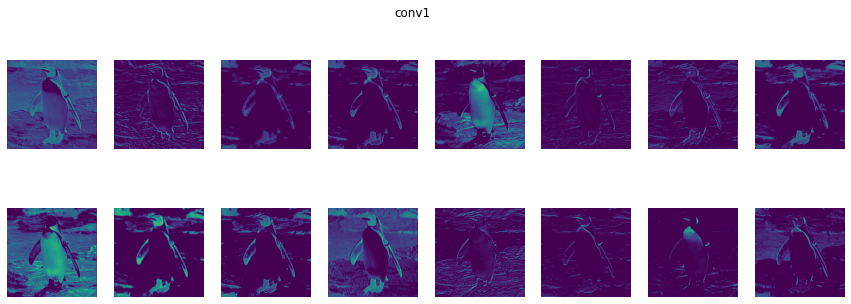

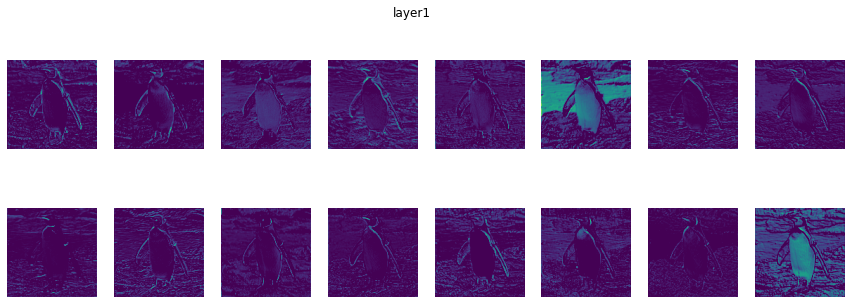

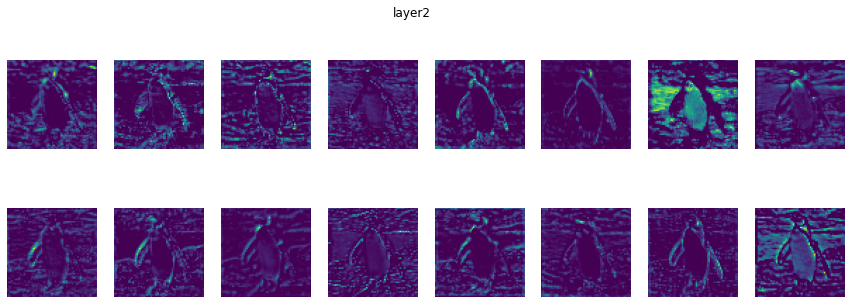

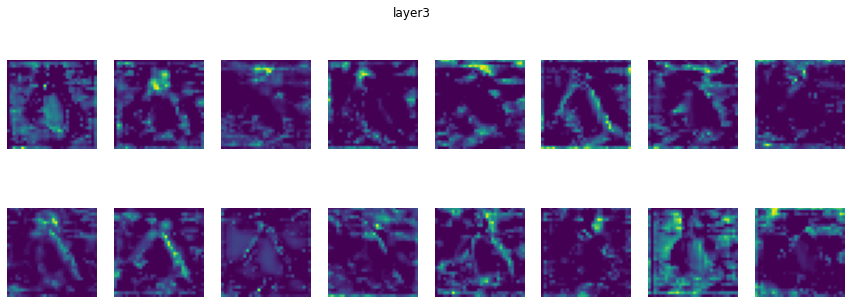

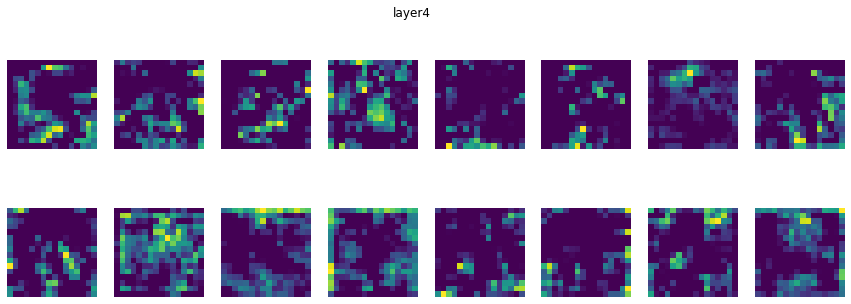

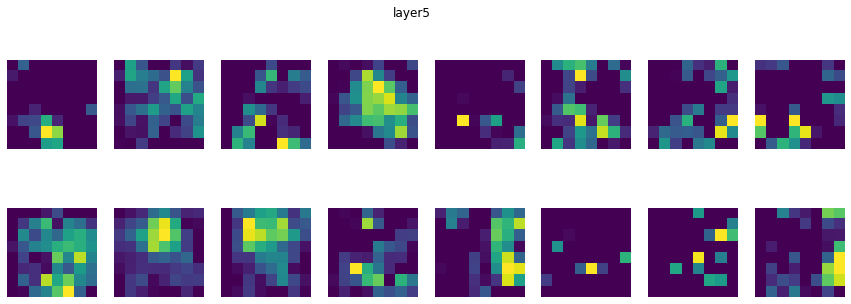

In [50]:
# Visualize the figure here, so it is exported nicely
plot_model_features()  

<!-- END QUESTION -->

## Submission
Git push your finalized version of this notebook (with saved outputs) to the gitlab repo which you were assigned. You should request our tests once and check that the ```preview.pdf```:
* Passes all public tests (these are the same ones provided / embedded in the notebook itself)
* Contains your qualitative answers
* Contains your figures (confusion matrix and network features)

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [19]:
grader.check_all()

BatchNorm Layer results: All test cases passed!
BatchNorm Layer - 1 message: Shape Test Passed
BatchNorm Layer - 2 message: Type Test Passed
BatchNorm Layer - 3 message: Param Name Test Passed
BatchNorm Layer - 4 message: Param Shape Test Passed

Convolution Layer results: All test cases passed!
Convolution Layer - 1 message: Shape Test Passed
Convolution Layer - 2 message: Type Test Passed
Convolution Layer - 3 message: Param Name Test Passed
Convolution Layer - 4 message: Param Shape Test Passed

Linear Layer results: All test cases passed!
Linear Layer - 1 message: Shape Test Passed
Linear Layer - 2 message: Type Test Passed
Linear Layer - 3 message: Param Name Test Passed
Linear Layer - 4 message: Param Shape Test Passed

MaxPool Layer results: All test cases passed!
MaxPool Layer - 1 message: Shape Test Passed
MaxPool Layer - 2 message: Type Test Passed